C:\Users\Siyu\AppData\Local\Temp\2\ipykernel_8856\1945487074.py:26: DtypeWarning: Columns (32,51,83,102) have mixed types. Specify dtype option on import or set low_memory=False.
  df_with_home = pd.read_csv(file_with_home)
C:\Users\Siyu\AppData\Local\Temp\2\ipykernel_8856\1945487074.py:27: DtypeWarning: Columns (50,101) have mixed types. Specify dtype option on import or set low_memory=False.
  df_no_home = pd.read_csv(file_no_home)
C:\Users\Siyu\AppData\Local\Temp\2\ipykernel_8856\1945487074.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour_range = pd.date_range(start=start.floor("H"), end=end.ceil("H"), freq="H", tz="UTC")
C:\Users\Siyu\AppData\Local\Temp\2\ipykernel_8856\1945487074.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hour_range = pd.date_range(start=start.floor("H"), end=end.ceil("H"), freq="H", tz="UTC")


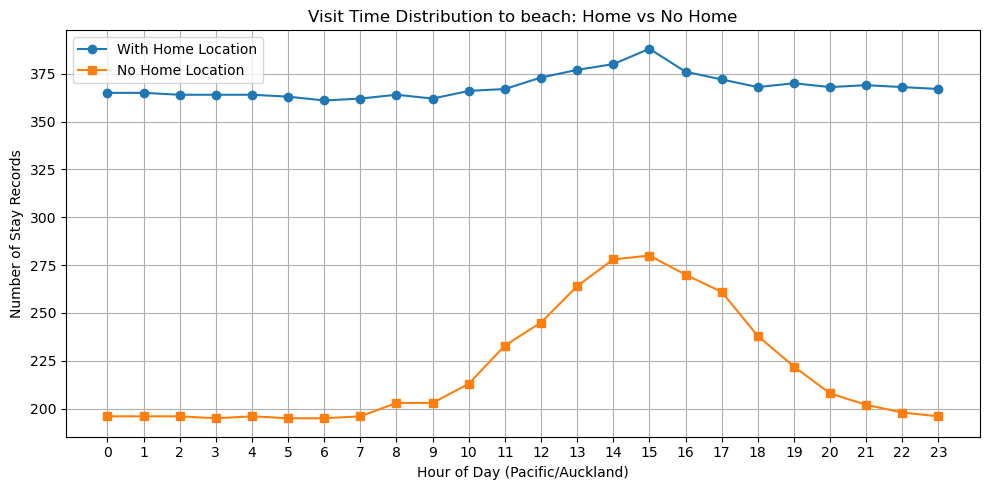

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def expand_stay_hours(df):
    df["start_time"] = pd.to_datetime(df["start_time"], utc=True)
    df["end_time"] = pd.to_datetime(df["end_time"], utc=True)

    records = []
    for _, row in df.iterrows():
        start = row["start_time"]
        end = row["end_time"]

        hour_range = pd.date_range(start=start.floor("H"), end=end.ceil("H"), freq="H", tz="UTC")

        for t in hour_range:
            if start <= t < end:
                records.append({"hour_utc": t})

    hourly_df = pd.DataFrame(records)
    hourly_count = hourly_df.groupby("hour_utc").size().reset_index(name="count")
    return hourly_count

file_with_home = r"\\tsclient\D\Siyu Zhao\data\Auckland region park\infostop_with_specific_homelocation_Voronoi_poi.csv"
file_no_home = r"\\tsclient\D\Siyu Zhao\data\Auckland region park\infostop_with_no_homelocation_Voronoi_poi.csv"

df_with_home = pd.read_csv(file_with_home)
df_no_home = pd.read_csv(file_no_home)

poi_type = "beach"
df_with_home = df_with_home[df_with_home["natural"] == poi_type].copy()
df_no_home = df_no_home[df_no_home["natural"] == poi_type].copy()

with_home_hourly = expand_stay_hours(df_with_home)
no_home_hourly = expand_stay_hours(df_no_home)

# 转为新西兰时间
with_home_hourly["local_hour"] = with_home_hourly["hour_utc"].dt.tz_convert("Pacific/Auckland").dt.hour
no_home_hourly["local_hour"] = no_home_hourly["hour_utc"].dt.tz_convert("Pacific/Auckland").dt.hour

# 聚合：统计每个 local_hour 有多少记录（因为多个 utc 小时可能对应同一个 local hour）
with_home_agg = with_home_hourly.groupby("local_hour")["count"].sum().reset_index()
no_home_agg = no_home_hourly.groupby("local_hour")["count"].sum().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(with_home_agg["local_hour"], with_home_agg["count"], label="With Home Location", marker='o')
plt.plot(no_home_agg["local_hour"], no_home_agg["count"], label="No Home Location", marker='s')

plt.title("Visit Time Distribution to beach: Home vs No Home")
plt.xlabel("Hour of Day (Pacific/Auckland)")
plt.ylabel("Number of Stay Records")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()